###  Install Required Libraries



In [1]:
"""%pip install torch
%pip install transformers
%pip install torchtext
%pip install openai
%pip install icecream
%pip install tqdm
%pip install tabulate
%pip install requests
%pip install scikit-learn
%pip install nltk
"""

'%pip install torch\n%pip install transformers\n%pip install torchtext\n%pip install openai\n%pip install icecream\n%pip install tqdm\n%pip install tabulate\n%pip install requests\n%pip install scikit-learn\n%pip install nltk\n'

In [2]:
import sys
sys.path.append('../')
from src.evaluation.goal_evaluator import GoalEvaluator
from src.extraction.extractor import generate_description, generate_actors, generate_high_level_goals, generate_low_level_goals
from src.mapping.APIs_mapping import generate_mapping_apis_goals, print_api_goal_mapping
from src.self_critique.refine_response import EvalMode, generate_response_with_reflection
from src.tools import get_api_list_from_swagger
from src.examples.shot_learning import ShotPromptingMode

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Luca\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Luca\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Luca\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Luca\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# Experiments

In [3]:
SHOTS_NUMBER = ShotPromptingMode.FEW_SHOT

### Description Generation

In [4]:
print("Description STARTING...")
description = generate_description("https://github.com/WebFuzzing/EMB/tree/master/jdk_8_maven/cs/rest-gui/genome-nexus#readme")
print("Description DONE...")
print(description)

Description STARTING...
Description DONE...
description='Genome Nexus is a platform designed for the automated annotation and interpretation of genetic variants, particularly in the context of cancer research. It integrates data from various sources to convert DNA variations into protein changes, predict the effects of mutations, and provide insights on mutation frequency, gene functionality, and clinical relevance. The platform offers documentation for users and provides several methods to deploy and run applications, including options for local and Docker setups.'


### Actors Extraction

In [15]:
actors, actors_score, actors_critique = generate_response_with_reflection(
    "Actors",
    generate_actors,
    define_args=description,
    eval_mode=EvalMode.ACTORS,
    eval_args=description,
    shotPromptingMode=SHOTS_NUMBER,
    max_attempts=3
)

Actors STARTING... (attempt 1)
No feedback provided!
Actors DONE...
actors=[Actor(name='Researchers', description='Individuals conducting cancer research and analyzing genetic variants.'), Actor(name='Bioinformaticians', description='Specialists who interpret genetic data and derive insights from genetic information.'), Actor(name='Clinicians', description='Medical professionals who utilize the platform to understand the clinical relevance of genetic mutations.'), Actor(name='Developers', description='Software engineers who deploy and run applications on the platform.')]
Evaluation for Actors STARTING...
Evaluation for Actors DONE...
Score: 8
Critique: The actors defined seem to cover the main roles that would interact with the Genome Nexus platform, including researchers, bioinformaticians, clinicians, and developers. However, the definition of actors could be improved by considering additional roles such as data curators or administrators who might be responsible for managing the dat

### High Level Goals Extraction

In [6]:
highLevelGoals, HL_score, HL_critique = generate_response_with_reflection(
    "High Level Goals",
    generate_high_level_goals,
    define_args=(description, actors),
    eval_mode=EvalMode.HIGH_LEVEL,
    shotPromptingMode=SHOTS_NUMBER,
    eval_args=(description, actors)
)

High Level Goals STARTING... (attempt 1)
No feedback provided!
This is the provided sys prompt:  You are a helpful assistant expert in software engineering tasks You're tasked with extracting high level goals from a software description for each provided actor that is expected to interact with the software. MUST focus only on functional requirements and ignore non-functional requirements. Focus only on requirements that benefit the end users of the software.
High Level Goals DONE...
goals=[HighLevelGoal(name='Automated Annotation of Genetic Variants', description='Allow researchers to automatically annotate genetic variants to facilitate cancer research insights.', actor=Actor(name='Researchers', description='Individuals conducting cancer research using genetic data.')), HighLevelGoal(name='Interpretation of Genetic Variants', description='Enable clinicians to interpret genetic variants effectively in the context of patient care.', actor=Actor(name='Clinicians', description='Medical pr

### Low Level Goals Extraction

In [7]:
lowLevelGoals, LL_score, LL_critique = generate_response_with_reflection(
    "Low Level Goals",
    generate_low_level_goals,
    define_args=(highLevelGoals),
    eval_mode=EvalMode.LOW_LEVEL,
    shotPromptingMode=SHOTS_NUMBER,
    eval_args=(description, actors, highLevelGoals)
)

Low Level Goals STARTING... (attempt 1)
No feedback provided!
This is the provided sys prompt:  You are a helpful assistant expert in software engineering tasksElicit low-level goals for a specific stakeholder in a software project  The low-level goals that you create MUST be structured to match against a set of API calls. Don't be too generic, for example, avoid goals like 'make the software fast', 'develop a web interface' etc.Each low-level goal MUST be phrased as an interaction with the system that could be implemented via an API call.Avoid generic goals like 'Access genetic data'. Instead, break them down into atomic actions linked to system capabilities.
Low Level Goals DONE...
low_level_goals=[LowLevelGoal(name='Enable researchers to upload genetic variant data for annotation', description='Researchers can upload genetic variant information into the system for automation of annotation.', high_level_associated=HighLevelGoal(name='Automated Annotation of Genetic Variants', descrip

### APIs Extraction from Swagger

In [8]:
print("API List STARTING...")
apiList = get_api_list_from_swagger()
print("API List DONE...")
print(apiList)

API List STARTING...
API List DONE...
[API(api_name='fetchVariantAnnotationPOST', api_path='/annotation', description='Retrieves VEP annotation for the provided list of variants', request_type='post'), API(api_name='fetchVariantAnnotationByIdPOST', api_path='/annotation/dbsnp/', description='Retrieves VEP annotation for the provided list of dbSNP ids', request_type='post'), API(api_name='fetchVariantAnnotationByIdGET', api_path='/annotation/dbsnp/{variantId}', description='Retrieves VEP annotation for the give dbSNP id', request_type='get'), API(api_name='fetchVariantAnnotationByGenomicLocationPOST', api_path='/annotation/genomic', description='Retrieves VEP annotation for the provided list of genomic locations', request_type='post'), API(api_name='fetchVariantAnnotationByGenomicLocationGET', api_path='/annotation/genomic/{genomicLocation}', description='Retrieves VEP annotation for the provided genomic location', request_type='get'), API(api_name='fetchVariantAnnotationGET', api_path=

### APIs Mapping to Low Level Goals

In [9]:
print("Mapping STARTING...")
mappings = generate_mapping_apis_goals(lowLevelGoals, apiList)
print("Mapping DONE")

Mapping STARTING...
hlg name:  Automated Annotation of Genetic Variants
Goal name:  Enable researchers to upload genetic variant data for annotation
Goal description:  Researchers can upload genetic variant information into the system for automation of annotation.
APIs:  (Not applicable with the current set of APIs)

hlg name:  Automated Annotation of Genetic Variants
Goal name:  Retrieve automatic annotations for uploaded genetic variants
Goal description:  Researchers can fetch the annotations generated for their variants after processing.
APIs:  fetchVariantAnnotationPOST, fetchVariantAnnotationGET, fetchVariantAnnotationByIdPOST

hlg name:  Interpretation of Genetic Variants
Goal name:  Enable clinicians to input patient data for variant interpretation
Goal description:  Clinicians can enter relevant patient information to assist in interpreting genetic variants.
APIs:  (Not applicable with the current set of APIs)

hlg name:  Interpretation of Genetic Variants
Goal name:  Access i

In [10]:
print(mappings[0].low_level_goal.high_level_associated.name)

Automated Annotation of Genetic Variants


### Mapping Table

In [11]:
print_api_goal_mapping(mappings)

╒══════════════════════════════════════════╤══════════════════════════════════════════════════════════════════════════════════╤═══════════════════════════════════════════════════════════════════════════════════════════════════════╤══════════════════════════════════════════════════════════════════════════════════════════════════════╕
│ High-Level Goal name                     │ Low-Level Goal name                                                              │ Low-Level Goal description                                                                            │ Mapped APIs                                                                                          │
╞══════════════════════════════════════════╪══════════════════════════════════════════════════════════════════════════════════╪═══════════════════════════════════════════════════════════════════════════════════════════════════════╪═══════════════════════════════════════════════════════════════════════════════════════════════════

# Evaluation

### Evaluation: Extracted High Level Goals 

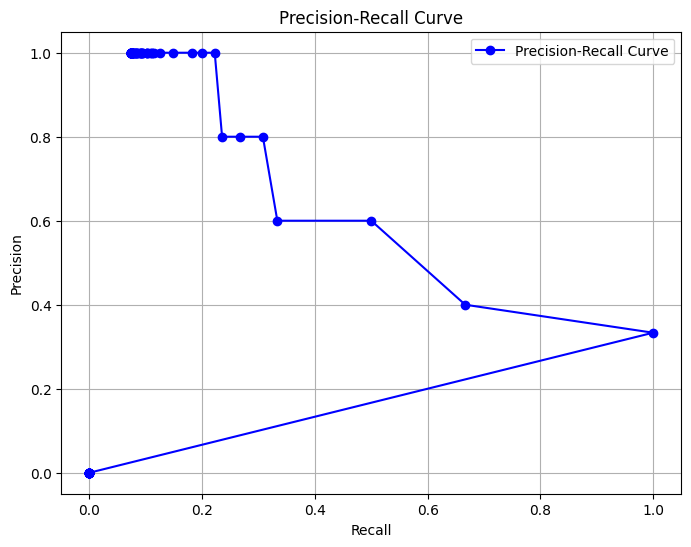

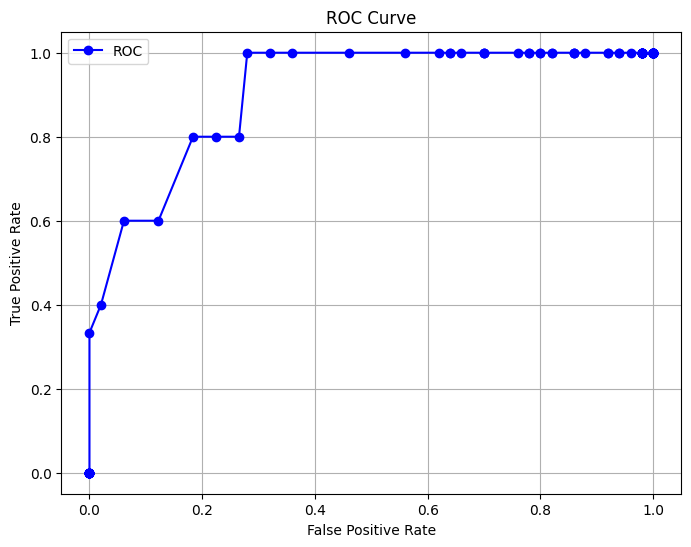

High Level ROC AUC: 0.9060136052066269
High Level Precision Recall Curve AUC: 0.44874308672683866


In [12]:
# List of high-level goals 
generated_goals = [goal.description for goal in highLevelGoals.goals]
manual_goals = ["Provide fast and automated annotation of genetic variants", "Enable high-throughput interpretation of genetic variants", "Integrate information from various existing resources", "Convert DNA changes to protein changes", "Predict functional effects of protein mutations", "Provide information about mutation frequencies", "Offer insights into gene function", "Detail variant effects", "Highlight clinical actionability of variants"]

evaluator = GoalEvaluator(preprocess = False)

auc_roc, auc_prec_rec = evaluator.print_roc_prec_rec_curve(generated_goals, manual_goals)
print("High Level ROC AUC:", auc_roc)
print("High Level Precision Recall Curve AUC:", auc_prec_rec)


### Evaluation: Extracted Low Level Goals 

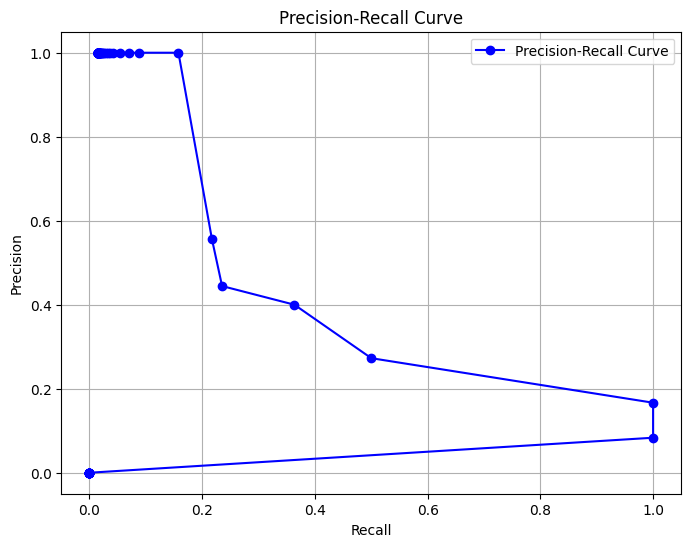

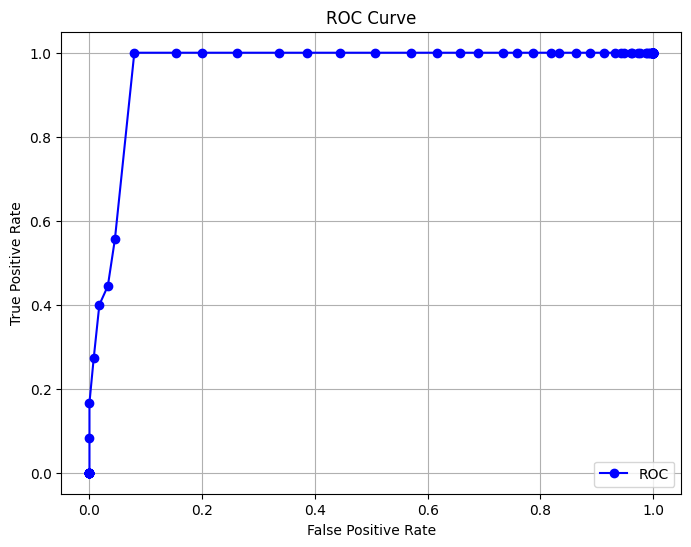

Low Level Goals ROC AUC: 0.9648535396136679
Low Level Goals Precision Recall Curve AUC: 0.3813597864368573


In [13]:
# List of low-level goals 
generated_low_level_goals = [goal.description for goal in lowLevelGoals.low_level_goals]

manual_low_level_goals = [
    # Provide a comprehensive one-stop resource for genetic variant annotation
    "Retrieve genetic variant data from multiple databases (e.g., dbSNP, ClinVar, COSMIC)",
    "Search and retrieve variant annotations from a user interface",
    "Annotate variants with clinical significance, mutation types, and related diseases",
    "Map genetic data to genome assemblies (e.g., GRCh38, hg19)",
    "Update variant information regularly from authoritative sources",
    
    # Enable fast and automated interpretation of cancer-related genetic variants
    "Analyze cancer-related mutations using automated tools",
    "Integrate gene expression data for cancer variant interpretation",
    "Identify cancer-related mutations linked to specific pathways",
    "Interpret large-scale cancer mutation datasets automatically",
    "Classify cancer mutations based on clinical relevance",
    
    # Support high-throughput analysis of genetic mutations
    "Process large genomic datasets in parallel",
    "Extract and transform mutation data from high-throughput sequencing formats (e.g., VCF, BAM)",
    "Perform mutation quality control and filtering",
    
    # Integrate data from multiple genomic databases
    "Fetch and harmonize data from various genomic databases",
    "Query integrated genomic databases for relevant mutation information",
    "Integrate multiple data sources with compatible formats for easy retrieval",
    
    # Convert DNA changes to corresponding protein changes
    "Map genetic mutations to corresponding protein-coding effects",
    "Convert mutations to amino acid changes for protein function analysis",
    "Predict the impact of mutations on protein structure using bioinformatics tools",
    
    # Predict the functional impact of protein mutations
    "Use prediction tools (e.g., PolyPhen, SIFT) to estimate mutation effects on protein function",
    "Build and apply machine learning models for functional impact prediction",
    "Rank mutations based on predicted severity of functional impact",
    
    # Provide information on mutation frequencies across datasets
    "Calculate mutation frequencies across various population groups",
    "Generate visual representations of mutation frequencies (e.g., histograms, pie charts)",
    "Provide mutation frequency data for specific diseases or conditions",
    
    # Offer insights into gene function and biological relevance
    "Retrieve gene function annotations from public databases like Gene Ontology (GO)",
    "Identify pathways and biological processes related to the mutated gene",
    "Link genetic variants to specific diseases or phenotypes based on annotations",
    
    # Detail the effects of genetic variants on protein function
    "Predict the effects of mutations on protein folding and stability",
    "Identify how mutations alter protein activity or structure",
    "Evaluate the impact of mutations on protein-protein interactions",
    
    # Highlight the clinical actionability of specific mutations
    "Link genetic mutations to clinical guidelines or treatment protocols",
    "Identify mutations with known clinical drug responses or therapeutic implications",
    "Provide actionable insights on mutations based on current clinical research"
]

evaluator_low_level = GoalEvaluator(preprocess = False)

auc_roc, auc_prec_rec = evaluator_low_level.print_roc_prec_rec_curve(generated_low_level_goals, manual_low_level_goals)
print("Low Level Goals ROC AUC:", auc_roc)
print("Low Level Goals Precision Recall Curve AUC:", auc_prec_rec)

### Evaluation: Extracted Actors 

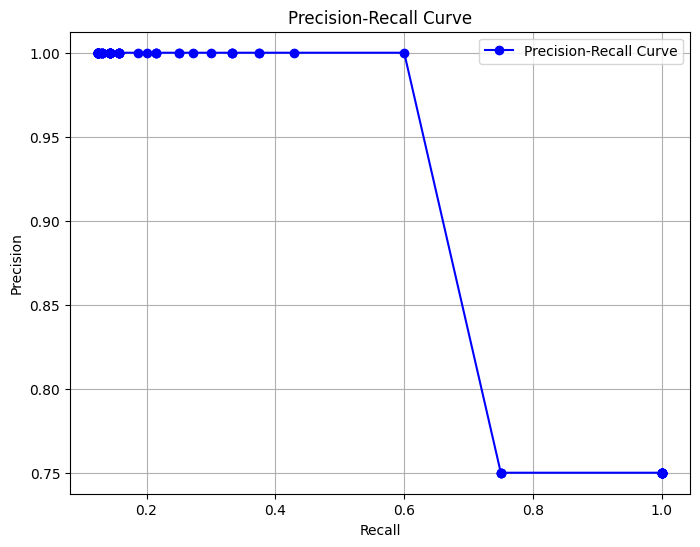

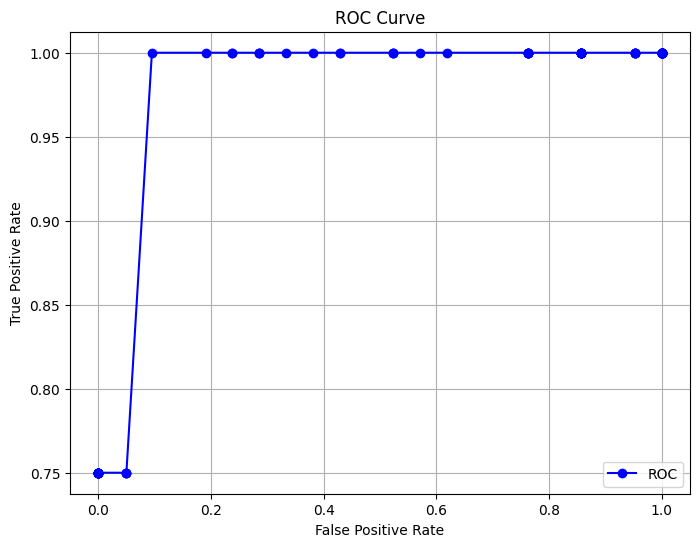

Actors ROC AUC: 0.9818452377257554
Actors Precision Recall Curve AUC: 0.16874999986312497


In [14]:
# List of actors
generated_actors = [actor.name for actor in actors.actors]
manual_actors = [
    "Researchers", "Clinicians", "biologists", "Database Administrators", "Bioinformaticians", "Geneticists"
]

evaluator = GoalEvaluator(preprocess = False)

auc_roc, auc_prec_rec = evaluator.print_roc_prec_rec_curve(generated_actors, manual_actors)
print("Actors ROC AUC:", auc_roc)
print("Actors Precision Recall Curve AUC:", auc_prec_rec)